#[01] EDA

In [2]:
%%capture
!pip install datasets

In [1]:
# packages
import pandas as pd
import seaborn as sns
from datasets import load_dataset

In [2]:
# YELP Dataset
yelp = load_dataset('yelp_review_full')

yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [3]:
# create dataset
train_ds = yelp['train']

train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [4]:
train_ds.features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [5]:
# convert to dataframe (if necessary)
train_ds.set_format('pandas')
train_ds[:]

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [6]:
# imbalance of dataset
val_count = pd.DataFrame(train_ds['label']).value_counts()

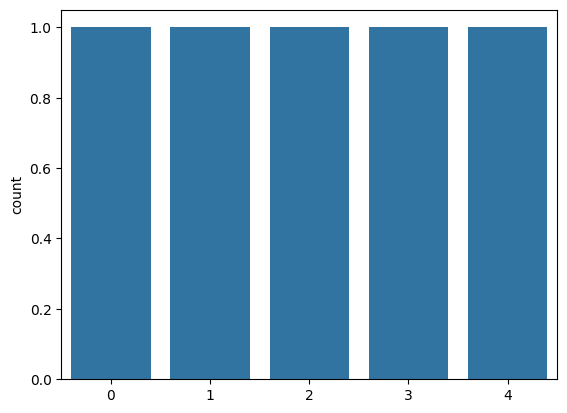

In [7]:
sns.countplot(val_count.tolist());

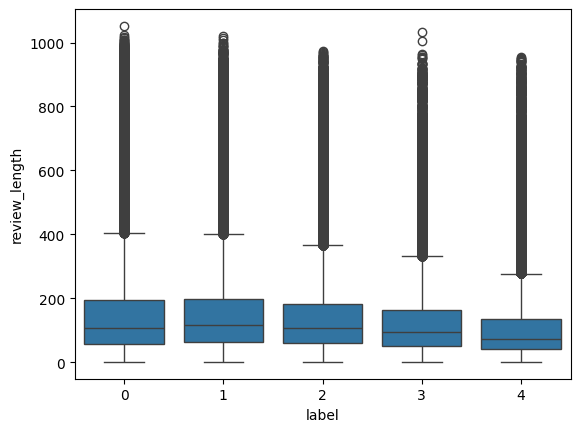

In [8]:
# understanding the texts
# count of words per review / per class
df_review_len_label = pd.DataFrame({'review_length':[len(s.split()) for s in train_ds['text']], 'label':train_ds['label']})
sns.boxplot(x='label', y='review_length', data = df_review_len_label);

#[02] Simple Model

In [3]:
# packages
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import AutoModel, DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
yelp = load_dataset('yelp_review_full')

yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [5]:
# create dataset
train_ds = yelp['train'].select(range(1000))

In [6]:
# Model and Tokenizer
model_name = 'distilbert-base-uncased'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

cuda


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Tokenizer
text = "Hello, this is a sample sentence!"

encoded_text = tokenizer(text, return_tensors='pt')
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 7099, 6251,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
# Tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'][0])
tokens

['[CLS]', 'hello', ',', 'this', 'is', 'a', 'sample', 'sentence', '!', '[SEP]']

In [9]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a sample sentence ! [SEP]'

In [10]:
# How large is the vocabulary?
tokenizer.vocab_size

30522

In [11]:
# Max context length
max_context_length = tokenizer.model_max_length
max_context_length

512

In [12]:
# Function for tokenization
def tokenize_text(batch):
    # padding...texts are filled with zeros based to longest example
    # truncation...texts are cut off after max_context_length
    return tokenizer(batch['text'], return_tensors='pt', padding='max_length', truncation=True)

In [13]:
yelp_encodings = train_ds.map(tokenize_text, batched=True, batch_size=128)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
yelp_encodings.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# encodings need to be converted to torch tensors

In [15]:
yelp_encodings

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [20]:
def get_last_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # [:, 0] refers to CLS token for complete sentence representation
    return {'hidden_state' : last_hidden_state[:, 0]}

In [21]:
yelp_hidden_states = yelp_encodings.map(get_last_hidden_state, batched=True, batch_size=128)
# will have additional column 'hidden_state'

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [22]:
yelp_hidden_states

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1000
})

In [23]:
import joblib
joblib.dump(yelp_hidden_states, 'yelp_hidden_states.joblib')

['yelp_hidden_states.joblib']

In [25]:
cutoff = 800
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff:])
y_test = np.array(yelp_hidden_states['label'][cutoff:])

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (800, 768), y_train.shape: (800,)
X_test.shape: (200, 768), y_test.shape: (200,)


In [26]:
# Dummy model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.165

In [28]:
# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.395

In [29]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.43

In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.33

#[03] Fine-tuning

In [1]:
# packages
from transformers import AutoModelForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import DatasetDict

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier

In [2]:
# dataset
yelp_hidden_states = joblib.load('yelp_hidden_states.joblib')

In [3]:
# Model and Tokenizer
model_name = 'distilbert-base-uncased'
device='cuda'
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer=DistilBertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Dataset
train_ds = yelp_hidden_states.select(range(0, 800))
eval_ds = yelp_hidden_states.select(range(800, 1000))

print(train_ds[0]['input_ids'].shape)
print(eval_ds[0]['input_ids'].shape)
print(yelp_hidden_states[800]['input_ids'].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])


In [5]:
# DatasetDict
yelp_ds_dict = DatasetDict({'train':train_ds, 'test':eval_ds})

In [40]:
%%capture
! pip install transformers[torch]

In [6]:
# Trainer Arguments
batch_size=8 # adapt BS to fit into memory
training_args = TrainingArguments(
    output_dir='./results', # output directory
    learning_rate=2e-5, # learning rate
    num_train_epochs=20, # total number of training epochs
    per_device_train_batch_size=batch_size, # batch size per device during training
    per_device_eval_batch_size=batch_size, # batch size for evaluation
    warmup_steps=500, # number of warmup steps for learning rate scheduler
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy='epoch',
    log_level='error',
    weight_decay=0.01, # strength of weight decay
    logging_dir='./logs' # directory for storing logs
)

In [7]:
# Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=yelp_ds_dict['train'],
                  eval_dataset=yelp_ds_dict['test'])

In [8]:
trainer.train()

Step,Training Loss
500,1.265100
1000,0.297000
1500,0.026300
2000,0.002500


TrainOutput(global_step=2000, training_loss=0.39771908342838286, metrics={'train_runtime': 232.3441, 'train_samples_per_second': 68.863, 'train_steps_per_second': 8.608, 'total_flos': 2119591772160000.0, 'train_loss': 0.39771908342838286, 'epoch': 20.0})

In [9]:
# get losses
trainer.evaluate()

{'eval_loss': 2.674147844314575,
 'eval_runtime': 0.8246,
 'eval_samples_per_second': 242.531,
 'eval_steps_per_second': 30.316,
 'epoch': 20.0}

In [10]:
# calcuate predictions
preds = trainer.predict(yelp_ds_dict['test'])

In [11]:
preds.metrics

{'test_loss': 2.674147844314575,
 'test_runtime': 0.8842,
 'test_samples_per_second': 226.181,
 'test_steps_per_second': 28.273}

In [12]:
np.argmax(preds.predictions, axis=1)

array([0, 4, 4, 4, 3, 3, 3, 2, 3, 2, 4, 4, 4, 1, 3, 1, 3, 2, 2, 1, 0, 2,
       2, 1, 2, 2, 3, 1, 0, 3, 1, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3,
       2, 1, 3, 4, 3, 2, 4, 4, 4, 1, 2, 4, 4, 0, 3, 4, 1, 3, 2, 2, 1, 3,
       3, 0, 4, 1, 4, 4, 2, 2, 1, 1, 1, 3, 2, 3, 1, 1, 2, 2, 2, 2, 2, 1,
       0, 3, 4, 2, 3, 1, 1, 2, 1, 2, 3, 2, 1, 1, 0, 2, 3, 1, 1, 1, 0, 3,
       1, 2, 2, 3, 3, 3, 1, 2, 2, 2, 4, 3, 0, 2, 3, 1, 3, 1, 3, 2, 4, 4,
       2, 4, 0, 1, 2, 3, 1, 3, 0, 1, 4, 3, 0, 3, 3, 2, 2, 3, 3, 3, 2, 1,
       2, 2, 1, 4, 2, 3, 4, 1, 3, 1, 0, 2, 4, 1, 0, 2, 2, 3, 4, 4, 3, 2,
       0, 1, 1, 1, 1, 0, 0, 2, 3, 1, 1, 3, 3, 3, 1, 1, 0, 3, 3, 3, 1, 2,
       3, 4])

<Axes: >

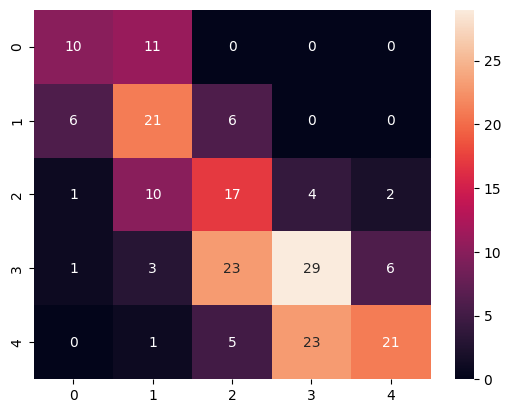

In [14]:
# confusion matrix
true_classes = yelp_ds_dict['test']['label']
preds_classes = np.argmax(preds.predictions, axis=1)
conf_mat = confusion_matrix(true_classes, preds_classes)
sns.heatmap(conf_mat, annot=True)

In [15]:
# accuracy
accuracy_score(true_classes, preds_classes)

0.49

In [16]:
# baseline classifier training
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(yelp_ds_dict['train']['label'], yelp_ds_dict['train']['label'])

DummyClassifier(strategy='most_frequent')

In [17]:
# baseline classifier accuracy
dummy_clf.score(yelp_ds_dict['test']['label'], yelp_ds_dict['test']['label'])

0.165

In [18]:
# inspect individual reviews
model_cpu = model.to('cpu')

# inference
with torch.no_grad():
    outputs = model_cpu(yelp_ds_dict['test']['input_ids'], yelp_ds_dict['test']['attention_mask'])

# loss calculation
pred_labels = torch.argmax(outputs.logits, dim=1)
loss = cross_entropy(outputs.logits, yelp_ds_dict['test']['label'], reduction='none')

df_individual_review = pd.DataFrame({'test':yelp_ds_dict['test']['text'],
                                     'label':yelp_ds_dict['test']['label'],
                                     'pred_label':pred_labels, 'loss':loss}).sort_values('loss', ascending=False).reset_index(drop=True)

In [19]:
df_individual_review

,test,label,pred_label,loss
0,This place has steadily improved over the year...,3,1,9.688507
1,"My husband and I stopped going here, back in 2...",4,1,9.254534
2,"Food is tasty, though portions are for the wai...",2,1,8.816463
3,For our last lunch in Pittsburgh we decided to...,0,1,8.682832
4,"Ugh... I got a plate with seisage, tofu scramb...",0,1,8.615578
...,...,...,...,...
195,I've found the service here to be pretty terri...,1,1,0.000629
196,Lamb burger was outright bad(tasted off and ch...,1,1,0.000596
197,I was determined to let this one pass (experie...,1,1,0.000588
198,I was underwhelmed with our dining experience....,1,1,0.000567


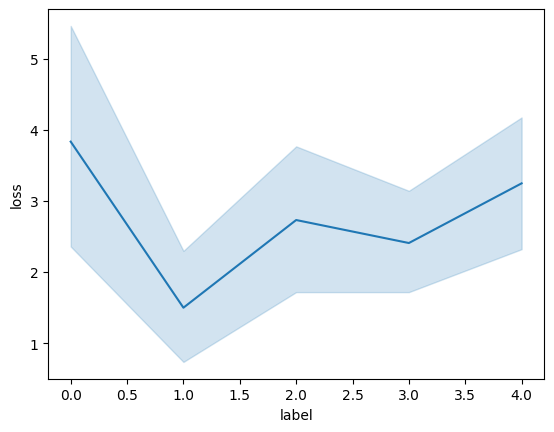

In [20]:
sns.lineplot(data=df_individual_review, x='label',y='loss');